In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [2]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-linear.splcds - 118.999[mbs]
(1) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-bspline.splcds - 118.925[mbs]
(2) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-curvefit.splcds - 125.594[mbs]
(3) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-uniformprior.splcds - 128.792[mbs]
(4) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.splcds - 6.286[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-linear.splcds - 118.999[mbs]


In [3]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_

def load_lcdataset(filename):
    assert filename.split('.')[-1]==C_.EXT_SPLIT_LIGHTCURVE
    return load_pickle(filename)

filedir = f'../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.splcds'

filedict = get_dict_from_filedir(filedir)
root_folder = filedict['*rootdir*']
cfilename = filedict['*cfilename*']
survey = filedict['survey']
lcdataset = load_lcdataset(filedir)
print(lcdataset['raw'].keys())
print(lcdataset['raw'].get_random_lcobj(False).keys())
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.splcds
dict_keys(['data', 'survey', 'description', 'band_names', 'class_names', 'obs_is_flux'])
dict_keys(['days', 'obs', 'obse', 'y', 'synthetic'])
LCDataset:
[outliers - samples 10]
(*) obs_samples: 541 - min_len: 14 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 1.0[days]
(g) obs_samples: 260 - min_len: 6 - max_dur: 408.0[days] - dur(p50): 133.7[days] - cadence(p50): 3.0[days]
(r) obs_samples: 281 - min_len: 8 - max_dur: 376.0[days] - dur(p50): 128.7[days] - cadence(p50): 3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 44]
(*) obs_samples: 990 - min_len: 7 - max_dur: 298.1[days] - dur(p50): 40.0[days] - cadence(p50): 1.0[days]
(g) obs_samples: 409 - min_len: 0 -

> loading: ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-linear.splcds
100%|██████████| 50/50 [01:21,  1.63s/it, training id: 49]


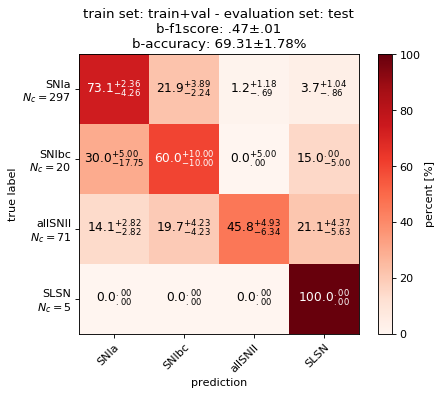

 16%|█▌        | 8/50 [01:29, 11.76s/it, training id: 7]

In [ ]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_
from lcfats.classifiers import get_fitted_classifiers, evaluate_classifiers
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
from flamingchoripan.datascience.statistics import XError
import matplotlib.pyplot as plt

max_model_ids = 50
test_lcset_name = 'test'
methods = ['linear', 'bspline', 'curvefit', 'uniformprior']
for method in methods:
    new_cfilename = f'{cfilename}_method-{method}'
    filedir = f'{root_folder}/{new_cfilename}.{C_.EXT_SPLIT_LIGHTCURVE}'
    lcdataset = load_lcdataset(filedir)
    rf_results = {}
    train_lcset_names = ['train+val', f'train+val.{method}', f'train+val.{method}']
    remove_reals = [False for _ in train_lcset_names]
    remove_reals[-1] = True
    for train_lcset_name,remove_real in zip(train_lcset_names, remove_reals):
        load_rootdir = f'../save/{survey}/{new_cfilename}/features'
        fit_kwargs = {
            'max_model_ids':max_model_ids,
            'remove_real_samples':remove_real,
        }
        classifier_dict, model_ids = get_fitted_classifiers(lcdataset, train_lcset_name, load_rootdir, **fit_kwargs)
        train_lcset_name = f'{train_lcset_name}{"-only" if remove_real else ""}'
        rf_results[train_lcset_name] = evaluate_classifiers(lcdataset, test_lcset_name, classifier_dict, model_ids, load_rootdir)
        
        ### plot cms
        d = rf_results[train_lcset_name]
        lcset_name = d[model_ids[0]]['lcset_name']
        class_names = d[model_ids[0]]['class_names']
        cms = [d[id]['cm'][None] for id in model_ids]
        f1score_xe = XError([d[id]['f1score'] for id in model_ids])
        title = f'train set: {train_lcset_name} - evaluation set: {lcset_name}\n'
        title += f'b-f1score: {f1score_xe}'
        cm_kwargs = {
            'title':title,
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'allSNII', 'SLSN'],
        }
        fig, ax = plot_custom_confusion_matrix(np.concatenate(cms, axis=0), class_names, **cm_kwargs)
        plt.show()
        
        ### print rank
        #print(classifier_dict[0]['rank'])
        
    save_filedir = f'../save/{survey}/{new_cfilename}/rf.res'
    save_pickle(save_filedir, rf_results)

In [ ]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
import pandas as pd

methods = ['linear', 'bspline', 'curvefit', 'uniformprior']
info_dict = {}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}_method-{method}'
    load_filedir = f'../save/{survey}/{new_cfilename}/rf.res'
    rf_results = load_pickle(load_filedir)
    model_ids = list(rf_results['train+val'].keys())
    d = {
        'b-accu[%] | real':XError([rf_results[f'train+val'][id]['accu']*100 for id in model_ids]),
        'b-f1score | real':XError([rf_results[f'train+val'][id]['f1score'] for id in model_ids]),
        'b-accu[%] | synth':XError([rf_results[f'train+val.{method}-only'][id]['accu']*100 for id in model_ids]),
        'b-f1score | synth':XError([rf_results[f'train+val.{method}-only'][id]['f1score'] for id in model_ids]),
        'b-accu[%] | real+synth':XError([rf_results[f'train+val.{method}'][id]['accu']*100 for id in model_ids]),
        'b-f1score | real+synth':XError([rf_results[f'train+val.{method}'][id]['f1score'] for id in model_ids]),
    }
    info_dict[f'method-{method}'] = d
    
info_df = pd.DataFrame.from_dict(info_dict, orient='index').reindex(list(info_dict.keys()))
info_df = info_df.sort_values(by=['b-f1score | real+synth'])
info_df['b-accu[%] | real'] = [v if k==0 else XError(None) for k,v in enumerate(info_df['b-accu[%] | real'].values)]
info_df['b-f1score | real'] = [v if k==0 else XError(None) for k,v in enumerate(info_df['b-f1score | real'].values)]
info_df

In [ ]:
%load_ext autoreload
%autoreload 2
from flamingchoripan.latex.latex_tables import LatexTable

latex_kwargs = {
    'caption':'$x_j$',
    'label':'???',
    'bold_criteriums':'max',
    'custom_tabular_align':'l|cc|cc|cc',
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)

In [ ]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
import pandas as pd

methods = ['linear', 'bspline', 'curvefit', 'uniformprior']
info_dict = {}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}_method-{method}'
    load_filedir = f'../save/{survey}/{new_cfilename}/rf.res'
    rf_results = load_pickle(load_filedir)
    model_ids = list(rf_results['train+val'].keys())
    info_dict[method] = rf_results['train+val'][model_ids[0]]['rank']
    
info_dict['curvefit']